O documento foi realizado no curso Data Science e Machine Learning realizado.

# Processamento de Linguagem Natural (PLN)
_Natural Language Processing (NLP) em Inglês_

## Análise de Sentimentos - Twitter

Identificar se o tweet é **racista/sexista** ou **não**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> h

Commands:
  d) Download a package or collection     u) Update out of date packages
  l) List packages & collections          h) Help
  c) View & Modify Configuration          q) Quit

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] 

True

### Ler dados

In [ ]:
train = pd.read_csv('D:\Trabalho\Data Science\Git Hub\Portfolio|Analise_de_Sentimentos_train.csv') #Coma Separated Values
test = pd.read_csv('D:\Trabalho\Data Science\Git Hub\Portfolio\Analise_de_Sentimentos_test.csv') 

In [ ]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [ ]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## Pré-processamento de Dados

### Tirar pontuações e caracteres especiais

In [ ]:
# Expressão Regular
# r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"

In [ ]:
train['tweet'] = train['tweet'].str.lower() #poderia deixar upper(). Fazer isso para não contar duas vezes a palavra

In [ ]:
train['tweet'] = train['tweet'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))

In [ ]:
def limpa_texto(data, col):
  """
  Tira pontuações e caracteres especiais, recebendo um dataframe e uma coluna 
  """
  data[col] = data[col].str.lower() #poderia deixar upper(). Fazer isso para não contar duas vezes a palavra
  data[col] = data[col].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))

In [ ]:
limpa_texto(test, 'tweet')
test.head()

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,white supremacists want everyone to see the ...
2,31965,safe ways to heal your acne altwaystoheal h...
3,31966,is the hp and the cursed child book up for res...
4,31967,3rd bihday to my amazing hilarious nephew el...


### Remover palavras comuns

Palavras comuns são conectores, conjunções, verbos de ligação, preposições, etc

stopwords.words são uma lista pronta de palavras comuns. Pode ser em english, portuguese, etc

In [ ]:
def remove_palavras_comuns(data, col):
    palavras_comuns = stopwords.words('english')
    lista_de_lista_de_palavras = data['tweet'].str.split()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [palavra for palavra in lista_de_lista_de_palavras[idx] \
                             if palavra not in palavras_comuns] #retorna palavra se palavra não estiver na lista de palavras comuns

In [ ]:
remove_palavras_comuns(train, 'tweet')

In [ ]:
remove_palavras_comuns(test, 'tweet')

In [ ]:
test.head()

,id,tweet
0,31963,"[studiolife, aislife, requires, passion, dedic..."
1,31964,"[white, supremacists, want, everyone, see, new..."
2,31965,"[safe, ways, heal, acne, altwaystoheal, health..."
3,31966,"[hp, cursed, child, book, reservations, alread..."
4,31967,"[3rd, bihday, amazing, hilarious, nephew, eli,..."


### Remover variações da mesma palavra

Tem a função de tirar a variação de conjugação verbal, etc
WordNetLematizer é a biblioteca que faz isso. 
Instanciar a biblioteca é trazer para o meu objeto.

In [ ]:
tira_variacao = WordNetLemmatizer()
tira_variacao.lemmatize('went', 'v')

'go'

In [ ]:
def tira_variacoes_de_palavras(data, col):
    tira_variacao = WordNetLemmatizer()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [tira_variacao.lemmatize(palavra,'v') \
                             for palavra in data[col][idx]]

In [ ]:
tira_variacoes_de_palavras(train, 'tweet')

In [ ]:
tira_variacoes_de_palavras(test, 'tweet')

In [ ]:
train.head()

,id,label,tweet
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ..."
2,3,0,"[bihday, majesty]"
3,4,0,"[model, love, u, take, u, time, ur]"
4,5,0,"[factsguide, society, motivation]"


### Engenharia de Recursos (Feature Engineering ) 
#### Quantidade de palavras por tweet

In [ ]:
train['palavras'] = train['tweet'].apply(len)

In [ ]:
test['palavras'] = test['tweet'].apply(len)

In [ ]:
train.head()

,id,label,tweet,palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3


## Análise Exploratória de Dados (AED)

### Distribuição das quantidades de palavras por "label"

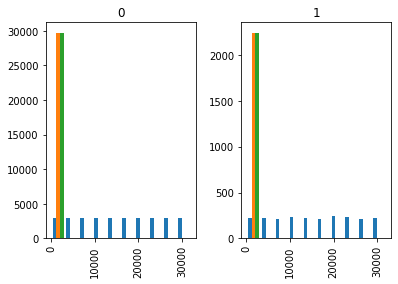

In [ ]:
train.hist(column = ['palavras'], by='label')
plt.show()

In [ ]:
train


,id,label,tweet,palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3
...,...,...,...,...
31957,31958,0,"[eat, isz, youuu]",3
31958,31959,0,"[see, nina, turner, airwaves, try, wrap, mantl...",14
31959,31960,0,"[listen, sad, songs, monday, morning, otw, wor...",8
31960,31961,1,"[sikh, temple, vandalise, calgary, wso, condem...",7


### Quantidade de cada "label"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


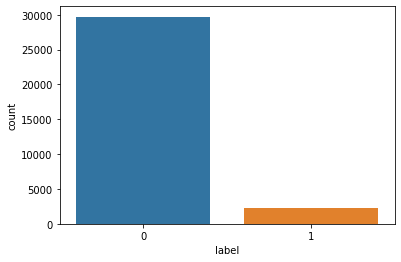

In [ ]:
sns.countplot('label', data = train)
plt.show()

O modelo preditivo nesse caso pode falar que tudo é zero e terá uma boa acuracidade. Portanto não é bom ficar com os dados dessa forma.

### Palavras frequêntes

#### Averiguar palavras mais frequêntes classificadas como "racistas ou sexistas"

In [ ]:
lista_de_listas = train.loc[train['label']==1]['tweet'].values

Aplicar compreensão de lista para resolver esse problema

Criar uma lista de palavras:

In [ ]:
palavras = [palavra for lista in lista_de_listas for palavra in lista]

In [ ]:
len(palavras)


18596

In [ ]:
import collections

In [ ]:
def gera_freq_palavras(lista):
  return collections.Counter(lista)

In [ ]:
freq_palavras = gera_freq_palavras(palavras)

In [ ]:
len(freq_palavras)

5285

In [ ]:
lista_de_palavras = []
lista_de_frequencias = []
for palavra, frequencia in freq_palavras.items():
  lista_de_palavras.append(palavra)
  lista_de_frequencias.append(frequencia)

In [ ]:
data_freq = pd.DataFrame({'palavra':lista_de_palavras, 'freq': lista_de_frequencias})

In [ ]:
data_freq.sort_values('freq', ascending = False, inplace = True)

In [ ]:
data_freq.head()

,palavra,freq
49,amp,283
69,trump,216
33,white,153
98,libtard,149
65,black,146


### Nuvem de Palavras 

In [ ]:
#pip install wordcloud se não tiver já instalado
from wordcloud import WordCloud

In [ ]:
nuvem = WordCloud(background_color = 'white')

In [ ]:
lista_slicing_topten = dict(data_freq[:20].values) #dicionário do slicing com os top 10 na lista de lista de frequencias transformada em lista

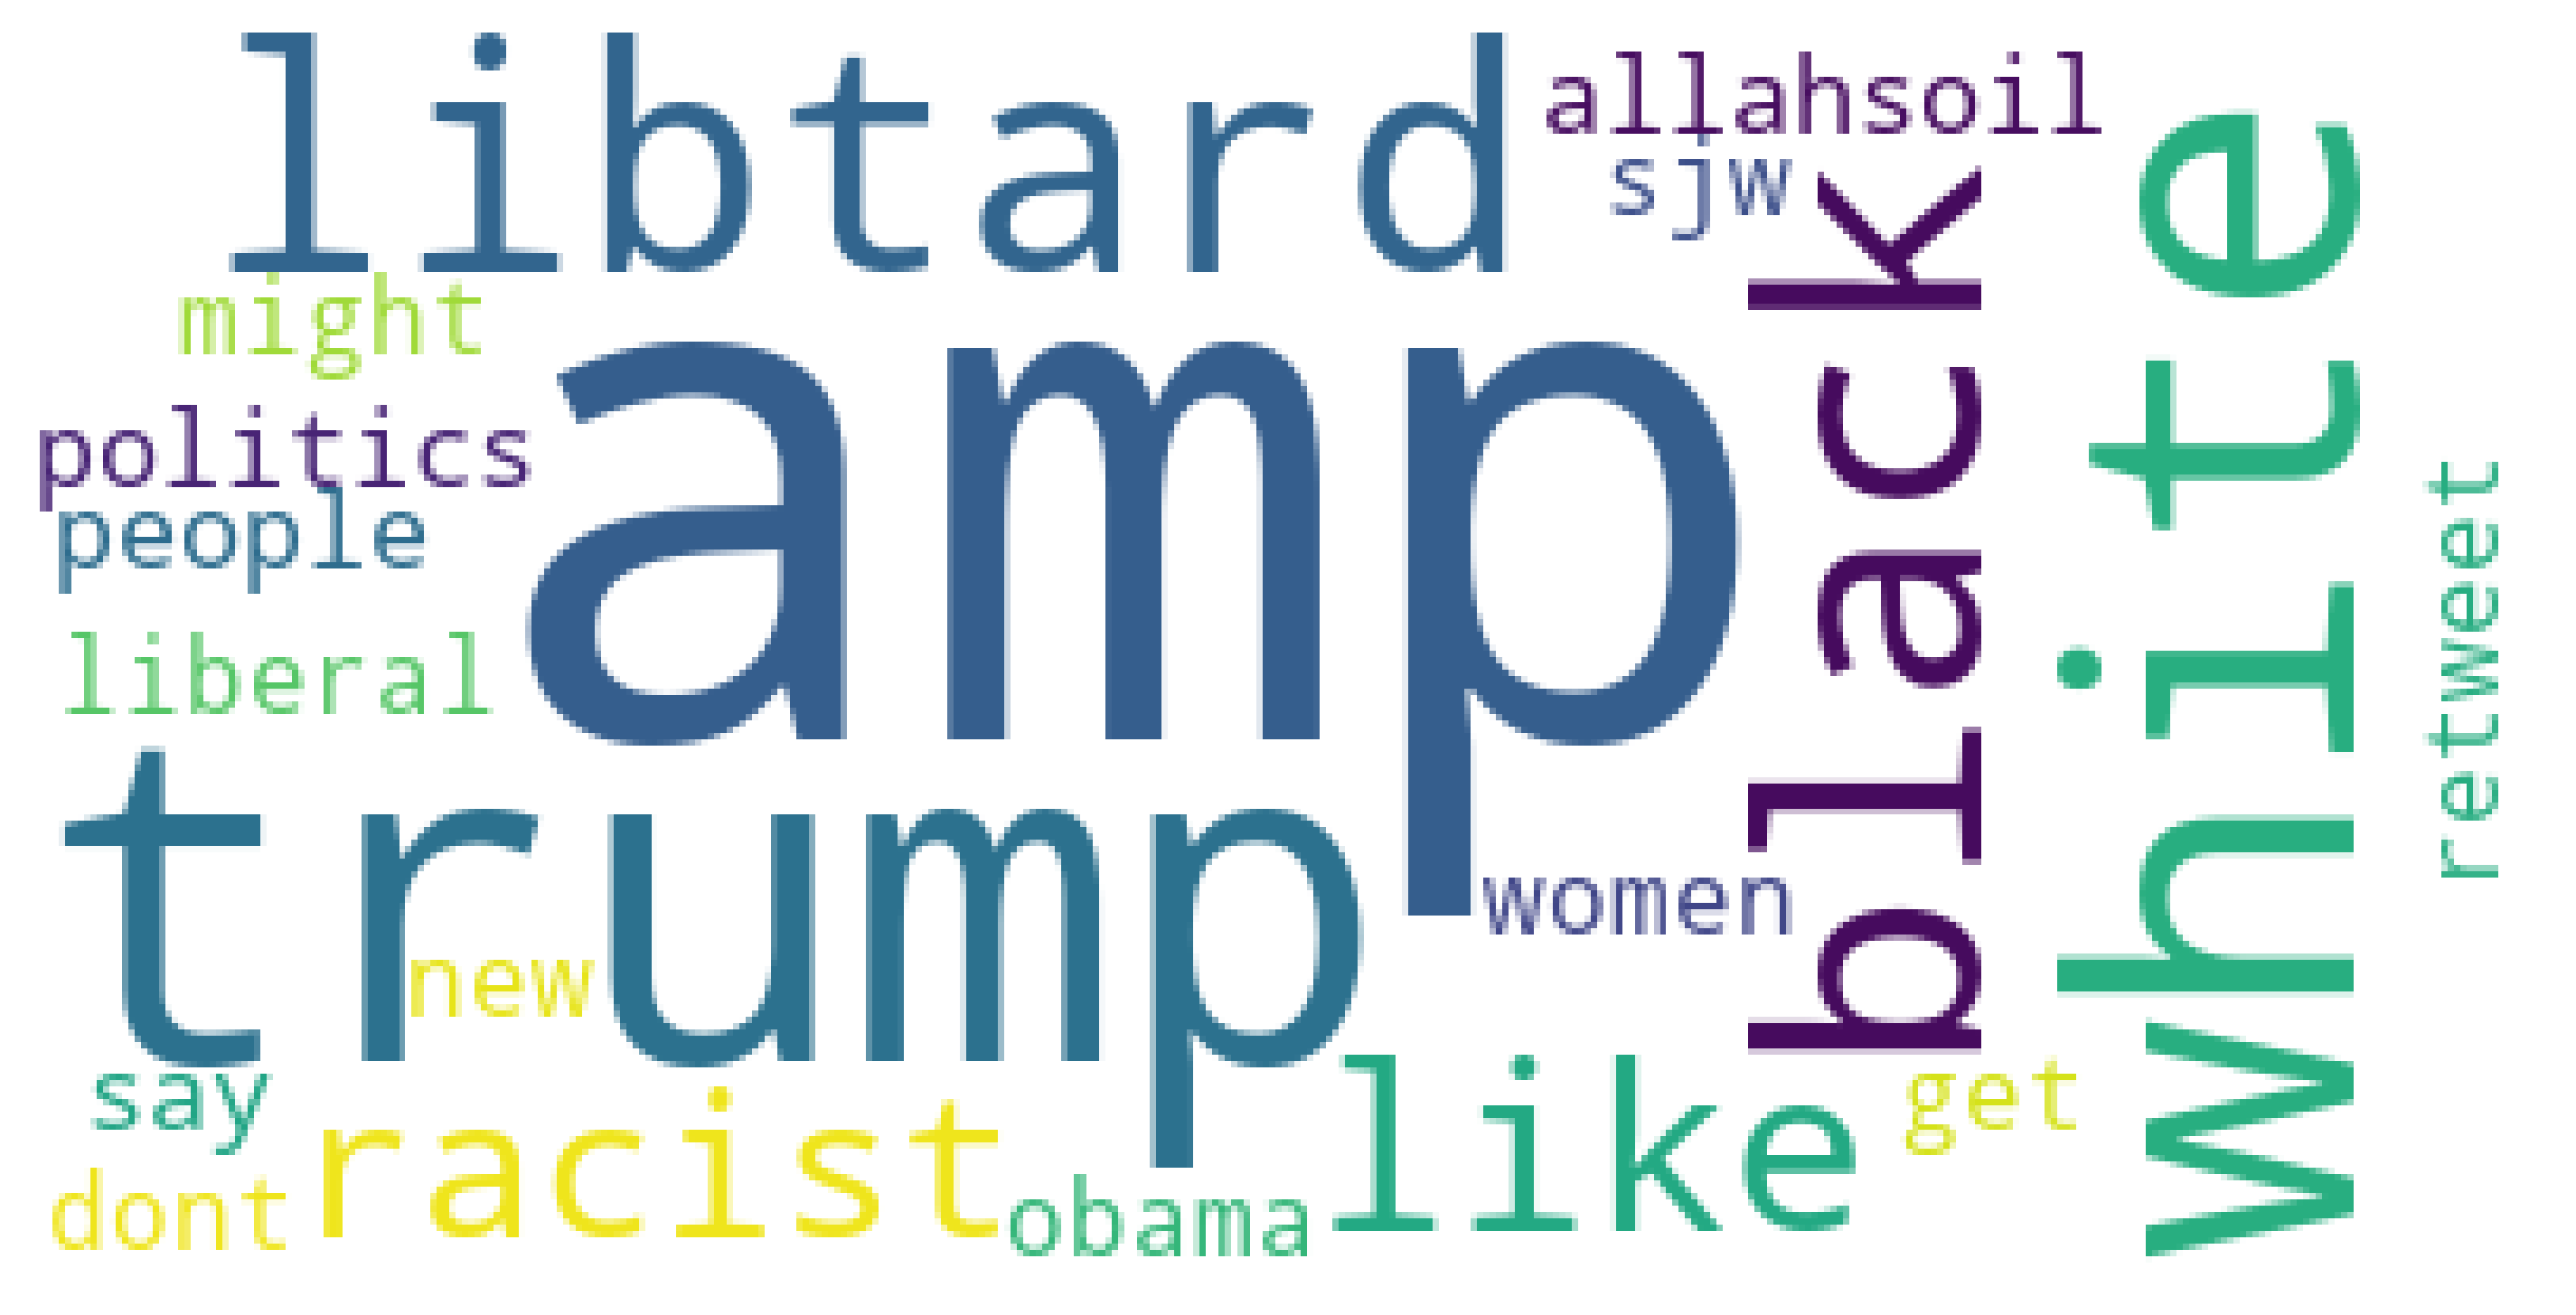

In [ ]:
plt.figure(figsize=(12,8), dpi = 300)
nuvem.generate_from_frequencies(lista_slicing_topten)
plt.imshow(nuvem)
plt.axis('off')
plt.show()

### Retornar para formato de texto

In [ ]:
train['tweet'][7]

['next',
 'school',
 'year',
 'year',
 'exams',
 'cant',
 'think',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl']

In [ ]:
' '.join(train['tweet'][7])

'next school year year exams cant think school exams hate imagine actorslife revolutionschool girl'

In [ ]:
train['tweet'] = train['tweet'].apply(lambda x: ' '.join(x))

In [ ]:
test['tweet'] = test['tweet'].apply(lambda x: ' '.join(x))

###  Solucionar problema de desequilibrio dos dados

O melhor nesse caso é avaliar o f1 score

In [ ]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

tentar deixar os dois dados com o mesmo tamanho

In [ ]:
from sklearn.utils import resample

In [ ]:
train_minoria = train.loc[train['label']==1]
len(train_minoria)

2242

In [ ]:
train_maioria = train.loc[train['label']==0]
len(train_maioria)

29720

In [ ]:
menor_para_maior = resample(train_minoria, replace=True, 
                            n_samples=len(train_maioria), 
                            random_state = 123)

In [ ]:
len(menor_para_maior)

29720

In [ ]:
menor_para_maior['label'].value_counts()

1    29720
Name: label, dtype: int64

In [ ]:
train_maioria['label'].value_counts()

0    29720
Name: label, dtype: int64

In [ ]:
menor_para_maior

,id,label,tweet,palavras
19492,19493,1,might libtard libtard sjw liberal politics,6
16151,16152,1,good place sta learn abt one person amp bigot ...,10
25144,25145,1,allahsoil bernanke bail wall street dump 600 b...,10
30902,30903,1,wait somebody call dont see anybody,6
16522,16523,1,white people expats rest us immigrants socialc...,9
...,...,...,...,...
30530,30531,1,homicides rise big cities year wall street jou...,11
21155,21156,1,major kind people arent talk enough via enviro...,8
30537,30538,1,may correct cant pay attention communist,6
6169,6170,1,look repug gop pay bigots,5


In [ ]:
train_equilibrado = pd.concat([menor_para_maior, train_maioria])

In [ ]:
len(train_equilibrado)

59440

In [ ]:
def equilibra_dados(train, pra_mais=True):
    train_minoria = train.loc[train['label']==1]
    train_maioria = train.loc[train['label']==0]
    if pra_mais:
        menor_pro_maior = resample(train_minoria, 
                           replace=True, 
                           n_samples=len(train_maioria), 
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, train_maioria])
    else:
        maior_pro_menor = resample(train_maioria, 
                           replace=True, 
                           n_samples=len(train_minoria), 
                           random_state=123)
        train_equilibrado = pd.concat([maior_pro_menor, train_minoria])
    return train_equilibrado

In [ ]:
train_equilibrado = equilibra_dados(train, pra_mais = False)

## Treinar Modelo

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = train_equilibrado['tweet']
y = train_equilibrado['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=123)

In [ ]:
X_train.shape, y_train.shape

((3138,), (3138,))

In [ ]:
sgd = Pipeline([
                ('countVector', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('modelo', SGDClassifier())
])

In [ ]:
sgd.fit(X_train, y_train)

Pipeline(steps=[('countVector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('modelo', SGDClassifier())])

In [ ]:
sgd_pred = sgd.predict(X_test)

In [ ]:
sgd_pred

array([0, 0, 0, ..., 0, 0, 1])

## Avaliar Performance do Modelo

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
sgd_score = f1_score(y_test, sgd_pred)

In [ ]:
sgd_score

0.8484848484848485

In [ ]:
y_pred = sgd.predict(test['tweet'])
y_pred

array([0, 0, 0, ..., 0, 0, 0])

## Data frame de predição

In [ ]:
predicao_df = pd.DataFrame({'id':test['id'], 'label':y_pred})

In [ ]:
predicao_df.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [ ]:
predicao_df.to_csv('pred_twitter.csv', index=False)

Fontes (em inglês):
* http://bit.ly/NLP-Twitter
* http://bit.ly/NLP-Twitter-Competition